#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/Users/adrian/Repos/seminar_critical-social-media-analysis/adrian_gruszczynski_assignment4/venv/bin/python


# Install dependencies:

In [3]:
!pip3 install umap-learn
!pip3 install scikit-learn-extra

You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 624kB 2.3MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-macosx_10_15_x86_64.whl size=114754 sha256=a3ddd8fc7a1ccd1603f58914d0dec43c849d67742e7d2d0cdf8ce1cec6b3bad4
  Stored in directory: /Users/adrian/Library/Caches/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra
You should consider upgrading via the 'pip install --upgrade pip' command.


# Imports

In [4]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [5]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.48316938
n_clusters: 102 silhouette_avg: 0.31719437
n_clusters: 202 silhouette_avg: 0.29383245
n_clusters: 302 silhouette_avg: 0.29105702
n_clusters: 402 silhouette_avg: 0.2813709
n_clusters: 502 silhouette_avg: 0.2807595
n_clusters: 602 silhouette_avg: 0.2780357
n_clusters: 702 silhouette_avg: 0.2782187
n_clusters: 802 silhouette_avg: 0.28287086
n_clusters: 902 silhouette_avg: 0.28162524


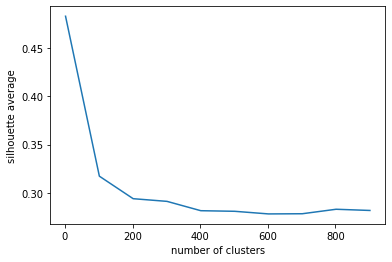

In [11]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [12]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 63      9
91     10
67     11
60     11
94     15
99     15
53     16
75     23
88     24
19     24
8      24
80     24
70     27
85     27
10     27
34     28
72     28
1      28
57     30
52     30
38     31
56     32
81     33
77     33
86     33
98     35
7      37
93     37
37     37
79     38
44     40
43     41
89     41
87     41
21     42
16     43
42     43
35     44
96     45
55     45
95     46
51     47
49     47
29     47
39     48
73     48
2      51
76     51
13     51
69     52
24     53
50     54
66     54
32     55
47     56
48     57
31     60
62     60
36     61
64     62
84     62
23     62
30     64
65     66
9      69
82     69
41     70
74     71
68     72
40     72
15     73
3      74
27     75
28     75
71     75
58     76
61     77
14     79
18     79
97     82
22     82
83     89
45     89
6      94
78     97
20     99
25    101
17    102
59    103
90    104
11    105
26    105
92    113
4     124
0     128
54    147
12    150
46    156
33  

In [13]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [14]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/Users/adrian/Repos/seminar_critical-social-media-analysis/adrian_gruszczynski_assignment4/venv/lib/python3.7/site-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

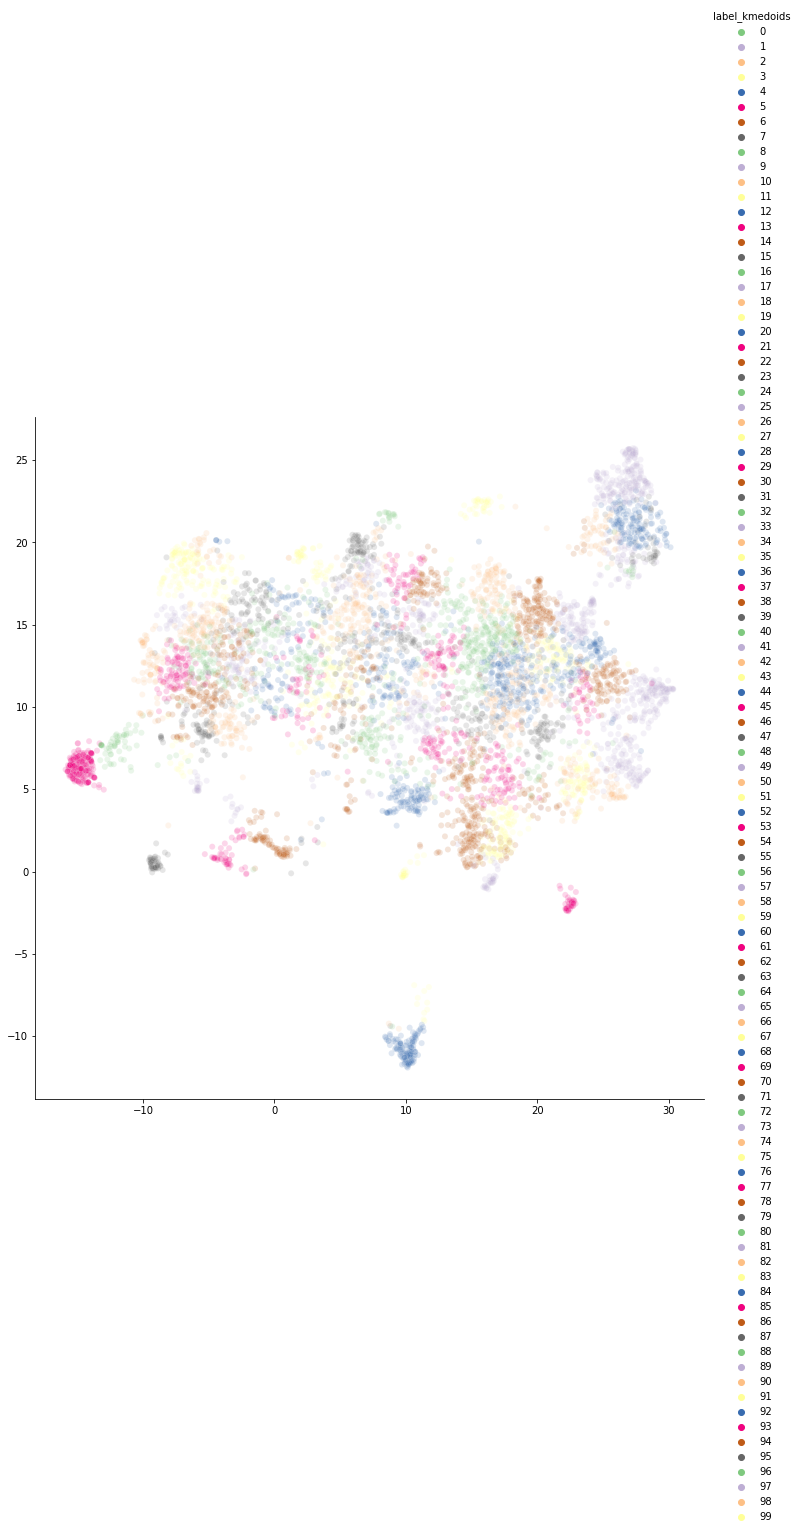

In [15]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

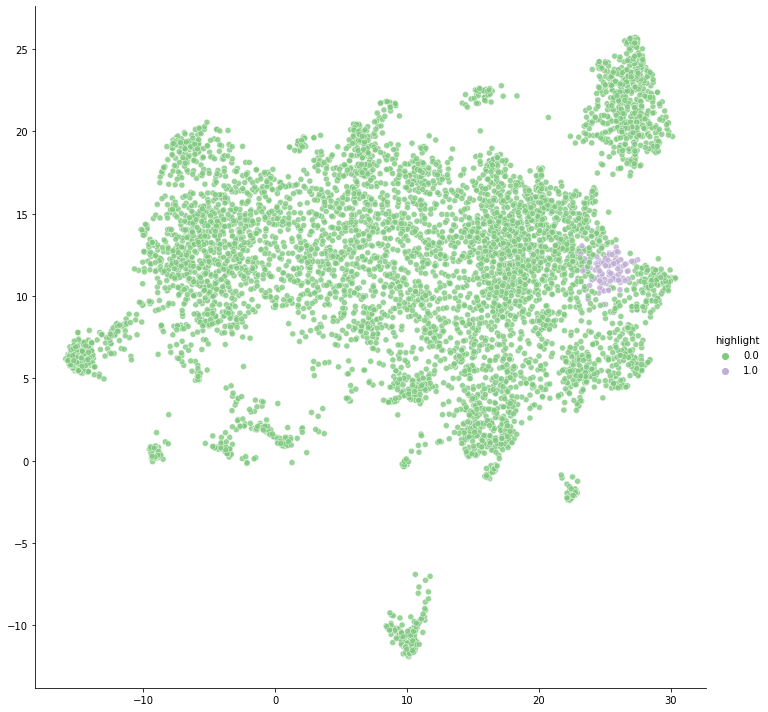

In [21]:
## Choose a cluster to higlight:
cluster_num = 6

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [22]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
4645,2017-04-19 16:43:03,thisnotjesus,basically you hate people and you want them to die to climate change.,1,basically you hate people and you want them to die to climate change.\n\n,-1.0,0,0.000000e+00,0.0
3161,2019-05-16 12:08:44,N A S,zakosist thank you for being open about it and reducing!!☺️🌼🌱,1,thank you for being open about it and reducing!!☺️🌼🌱\n\n,-1.0,1,0.000000e+00,0.0
890,2019-08-15 06:11:14,AishaTheBrave,"Go vegan, it&#39;s the biggest step each of us can take to reduce our carbon footprint and stop climate change!",0,"Go vegan, it's the biggest step each of us can take to reduce our carbon\nfootprint and stop climate change!\n\n",-1.0,2,0.000000e+00,0.0
4990,2017-04-19 14:04:49,Jason Schwarzman,I don&#39;t get why they&#39;re acting like it&#39;s OUR burden. This is for the government to deal with. NOT us,0,I don't get why they're acting like it's OUR burden. This is for the\ngovernment to deal with. NOT us\n\n,-1.0,3,2.980232e-07,0.0
3778,2017-04-20 10:25:34,SubFeed Sub,"Wow your stupid, he ment that if we could see Co2 in the air, we would've delt with it",1,"Wow your stupid, he ment that if we could see Co2 in the air, we would've delt\nwith it\n\n",-1.0,4,0.000000e+00,0.0
4125,2017-04-19 22:01:05,Foxtrot 515,Fake,0,Fake\n\n,-1.0,5,5.960464e-08,0.0
4676,2017-04-19 15:34:02,InternetzHero,"Have you ever heard of the 'Hockey Stick graph'. It's not the fact that the Earth is warming that's the problem, it's that we are heating it in decades what naturally takes hundreds upon hundreds of years. Also, in Australia our past Labor government pushed clean energy home ownership (namely solar panals) through government subsidies.This is decentralized, and thus places energy production out of the control of the government or big corporations, who control the traditional power resources. I think the program is still going (not sure if the idiots have gotten do it yet)",1,"Have you ever heard of the 'Hockey Stick graph'. It's not the fact that the\nEarth is warming that's the problem, it's that we are heating it in decades\nwhat naturally takes hundreds upon hundreds of years. Also, in Australia our\npast Labor government pushed clean energy home ownership (ly solar panals)\nthrough government subsidies.This is decentralized, and thus places energy\nproduction out of the control of the government or big corporations, who\ncontrol the traditional power resources. I think the program is still going\n(not sure if the idiots have gotten do it yet)\n\n",-1.0,6,0.000000e+00,1.0
2374,2017-12-12 05:06:36,Dayvideo,He said it: apathy to action,1,He said it: apathy to action\n\n,-1.0,7,5.960464e-08,0.0
3116,2017-04-26 11:01:37,Lionel B.,"I have the solution: let&#39;s put a new tax on the sun, and problem will be solved, right????<br /><br />The global average concentration of CO2 in Earth&#39;s atmosphere is currently about 0.04%<br />Above the ocean in warm environments, the percentage of water vapor (another greenhouse effect gas) within the Earth&#39;s atmosphere can be as high as 4 percent...<br /><br />HMMMMMMMM , think people, think and educate yourself !<br /><br /><a href=""https://www.acs.org/content/acs/en/climatescience/climatesciencenarratives/its-water-vapor-not-the-co2.html"">https://www.acs.org/content/acs/en/climatescience/climatesciencenarratives/its-water-vapor-not-the-co2.html</a>",0,"I have the solution: let's put a new tax on the sun, and problem will be\nsolved, right???? \n \nThe global average concentration of CO2 in Earth's atmosphere is currently\nabout 0.04% \nAbove the ocean in warm environments, the percentage of water vapor (another\ngreenhouse effect gas) within the Earth's atmosphere can be as high as 4\npercent... \n \nHMMMMMMMM , think people, think and educate yourself ! \n \n\nwater-vapor-not-the-co2.html\n\n",-1.0,8,0.000000e+00,0.0
1367,2019-05-08 04:05:19,mark schuette,@Evagelos Drinis if you wa

In [23]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  128 mean distance from center:  0.001918664202094078 Proportion of replies: 40.625
1 number of samples:  28 mean distance from center:  0.0013766543816018384 Proportion of replies: 64.28571428571429
2 number of samples:  51 mean distance from center:  0.0015434095985256135 Proportion of replies: 50.98039215686274
3 number of samples:  74 mean distance from center:  0.0025759678464964963 Proportion of replies: 54.054054054054056
4 number of samples:  124 mean distance from center:  0.0004505438027990749 Proportion of replies: 29.838709677419356
5 number of samples:  231 mean distance from center:  0.00040518257264920976 Proportion of replies: 66.23376623376623
6 number of samples:  94 mean distance from center:  0.0012250657164258882 Proportion of replies: 60.638297872340424
7 number of samples:  37 mean distance from center:  0.002474398206686601 Proportion of replies: 72.97297297297297
8 number of samples:  24 mean distance from center:  0.0026536485165706836 Pro

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [24]:
# Choose a cluster to print
cluster_number =   20
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 99
Average Distance from cluster center: 8.858816e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
2838,2019-05-01 02:06:39,Ramon Preciado,Doesnt matter what america does china and India have the biggest consumer waste and pollution and it is growing.,1,Doesnt matter what america does china and India have the biggest consumer\nwaste and pollution and it is growing.\n\n,-1.0,20,0.000000e+00,0.0
1778,2019-09-27 09:52:05,Nathan Smith,When China and India create the most pollution tho,1,When China and India create the most pollution tho\n\n,-1.0,20,0.000000e+00,0.0
5922,2017-04-19 20:30:49,I play video games,"Sina yes china is the worlds number one polluter but that is because of westerns companies who has their factories in China. If you look at the people, Americans are still number one.",1,"yes china is the worlds number one polluter but that is because of\nwesterns companies who has their factories in China. If you look at the\npeople, Americans are still number one.\n\n",-1.0,20,2.384186e-07,0.0
5324,2017-04-19 13:48:01,Juicicle,"I know China has prominent levels of pollution but holy your comment suggests that China is the only source of pollution. Also if everyone goes vegan billions of farm animals would be purposeless and without knowledge on how they would live in the wild they would die, and millions of farmers would lose their jobs and eventually die along with their starving families and so on... Holy cow we ARE screwed!",1,"I know China has prominent levels of pollution but holy your comment suggests\nthat China is the only source of pollution. Also if everyone goes vegan\nbillions of farm animals would be purposeless and without knowledge on how\nthey would live in the wild they would die, and millions of farmers would lose\ntheir jobs and eventually die along with their starving families and so on...\nHoly cow we ARE screwed!\n\n",-1.0,20,2.980232e-07,0.0
5720,2017-04-19 14:58:42,Nirbhay Thacker,"well, because they don't pollute as much as the US, the reason we have so much pollution is because there are 8 times as many people in INDIA and CHINA than the US.In fact there are more people in INDIA alone than the US and EU combined. The per capita CO2 emission is 1.6 tonnes in India and 16.7 tonnes in the US. So the commenter is right, americans are bad at thinking.",1,"well, because they don't pollute as much as the US, the reason we have so much\npollution is because there are 8 times as many people in INDIA and CHINA than\nthe US.In fact there are more people in INDIA alone than the US and EU\ncombined. The per capita CO2 emission is 1.6 tonnes in India and 16.7 tonnes\nin the US. So the commenter is right, americans are bad at thin.\n\n",-1.0,20,5.364418e-07,0.0
1710,2020-04-02 06:21:09,Gabriela Quiñones,Luca Caldari actually if you look in your closet. or around your house you are gonna notice that almost everything it’s from china. plus china it’s one of the more contaminated land all those gasses fly and go into the ozone layer. it’s not all about USA. It’s about everyone. we all live in the same habitad. we are part of the Earth. EARTH ITS THE HOUSE OF EVERYONE!! WE NEED TO TAKE CARR OF HER!!,1,actually if you look in your closet. or around your house you are\ngonna notice that almost everything it’s from china. plus china it’s one of\nthe more contaminated land all those gasses fly and go into the ozone layer.\nit’s not all about USA. It’s about everyone. we all live in the same habitad.\nwe are part of the Earth. EARTH ITS THE HOUSE OF EVERYONE!! WE NEED TO TAKE\nCARR OF HER!!\n\n,-1.0,20,6.556511e-07,0.0
1752,2019-11-20 03:46:17,Professor Zoltan,"@Alexandre Beaudry it's strange how we all seem to target America. China is officially the highest polluters on this planet and have committed to reduce their CO2 emissions when they peak at 2030. This is their Paris agreement, fact but let's not talk about that. Agreed?",1,"@ it's strange how we all seem to target America. China is\nofficially the highest pollut

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 18
#your label
label_manual = 'music'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')